In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Ordered roughly by accuracy
cases = ['DUP22q11_2','DEL15q11_2','DUP1q21_1','DEL1q21_1','DUP16p11_2','DEL16p11_2','DEL22q11_2','ADHD','ASD','SZ','BIP']

case_labels =       ['BIP                  n=44',
                    'SZ                   n=283',
                    'ASD                 n=472',
                    'ADHD              n=223',

                    'DEL 22q11.2     n=43',
                    'DEL 16p11.2      n=32',
                    
                    'DUP 16p11.2     n=35',
                    'DEL 1q21.1       n=25',
                    'DUP 1q21.1       n=19',
                    'DEL 15q11.2    n=103',
                    'DUP 22q11.2     n=22']
case_labels.reverse()

p_single = '../../results_reviews/baseline/deeper/'
p_mtl = '../../results_reviews/mtl/deeper/'

In [3]:
#############
# BASELINES #
#############

# ACCURACY:
# balanced baseline: 0.5
bip_base = 72
sz_base = 56
adhd_base = 61
baselines = pd.DataFrame([0.72,0.56,0.61], index = ['BIP','SZ','ADHD'], columns=['acc'])

# F1:
# balanced baseline: 0.6666
baselines['f1'] = 2*baselines['acc']/(baselines['acc'] + 1)
baselines

# AUC? leave at 0.5 for now?


,acc,f1
BIP,0.72,0.837209
SZ,0.56,0.717949
ADHD,0.61,0.757764


# Load Data

In [4]:
# Single Task
st_data_conn = []
for case in cases:
    folds_conn = []
    for fold in range(5):
        # Connectomes
        p_parent = os.path.join(p_single, f"{case}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[case])

    st_data_conn.append(folds_conn)

st_data_conn = dict(zip(cases,st_data_conn))

In [5]:
# Multi-task
mtl_data_conn = []
for fold in range(5):
    # Connectomes
    p_parent = os.path.join(p_mtl, f"fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Scores

In [6]:
# Single Task
st_acc_conn = []
st_f1_conn = []
st_auc_conn = []
for case in cases:
    # Accuracy
    acc_vals = [st_data_conn[case][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc_conn.append(acc_vals)

    # F1
    f1_vals = [st_data_conn[case][fold]['F1/test'].iloc[-1] for fold in range(5)]
    st_f1_conn.append(f1_vals)

    # AUC
    auc_vals = [st_data_conn[case][fold]['AUC/test'].iloc[-1] for fold in range(5)]
    st_auc_conn.append(auc_vals)


st_acc_conn = pd.DataFrame(st_acc_conn, index=cases)
st_acc_conn_mean = st_acc_conn.mean(axis=1)
st_acc_conn_std = st_acc_conn.std(axis=1)

st_f1_conn = pd.DataFrame(st_f1_conn, index=cases)
st_f1_conn_mean = st_f1_conn.mean(axis=1)
st_f1_conn_std = st_f1_conn.std(axis=1)

st_auc_conn = pd.DataFrame(st_auc_conn, index=cases)
st_auc_conn_mean = st_auc_conn.mean(axis=1)
st_auc_conn_std = st_auc_conn.std(axis=1)

In [7]:
# Multi-task
mtl_acc_conn = []
mtl_f1_conn = []
mtl_auc_conn = []
for fold in range(5):
    df = mtl_data_conn[fold].transpose().reset_index()

    # Accuracy
    mtl_acc_conn.append(df[df['level_1']=='Accuracy/test'].set_index('level_0')[99])

    # F1
    mtl_f1_conn.append(df[df['level_1']=='F1/test'].set_index('level_0')[99])

    # AUC
    mtl_auc_conn.append(df[df['level_1']=='AUC/test'].set_index('level_0')[99])

mtl_acc_conn = pd.concat(mtl_acc_conn,axis=1)
mtl_acc_conn_std = mtl_acc_conn.std(axis=1)
mtl_acc_conn_mean = mtl_acc_conn.mean(axis=1)

mtl_f1_conn = pd.concat(mtl_f1_conn,axis=1)
mtl_f1_conn_std = mtl_f1_conn.std(axis=1)
mtl_f1_conn_mean = mtl_f1_conn.mean(axis=1)

mtl_auc_conn = pd.concat(mtl_auc_conn,axis=1)
mtl_auc_conn_std = mtl_auc_conn.std(axis=1)
mtl_auc_conn_mean = mtl_auc_conn.mean(axis=1)

# Tables

In [8]:
# Connectomes
df_conn = pd.concat([st_acc_conn_mean,mtl_acc_conn_mean,st_acc_conn_std,mtl_acc_conn_std,
                     st_f1_conn_mean,mtl_f1_conn_mean,st_f1_conn_std,mtl_f1_conn_std,
                     st_auc_conn_mean,mtl_auc_conn_mean,st_auc_conn_std,mtl_auc_conn_std],axis=1)
df_conn.columns = ['ST_mean_acc','MTL_mean_acc','ST_std_acc','MTL_std_acc',
                   'ST_mean_f1','MTL_mean_f1','ST_std_f1','MTL_std_f1',
                   'ST_mean_auc','MTL_mean_auc','ST_std_auc','MTL_std_auc']
df_conn

,ST_mean_acc,MTL_mean_acc,ST_std_acc,MTL_std_acc,ST_mean_f1,MTL_mean_f1,ST_std_f1,MTL_std_f1,ST_mean_auc,MTL_mean_auc,ST_std_auc,MTL_std_auc
DUP22q11_2,38.888889,50.000000,11.111111,16.666667,0.256111,0.457143,0.083896,0.254439,0.497083,0.562917,0.143943,0.114037
DEL15q11_2,56.829268,55.319396,5.949420,5.780076,0.441851,0.451306,0.051269,0.212051,0.596855,0.596230,0.082713,0.091742
DUP1q21_1,53.571429,62.142857,27.577581,20.297532,0.473810,0.506667,0.320369,0.339444,0.686667,0.583333,0.266250,0.083333
DEL1q21_1,66.000000,56.000000,20.736441,11.401754,0.603889,0.437143,0.352874,0.159405,0.656667,0.409167,0.197260,0.115485
DUP16p11_2,65.714286,57.142857,5.976143,11.293849,0.520693,0.396032,0.191280,0.333193,0.817917,0.623611,0.157272,0.079410
DEL16p11_2,73.461538,54.615385,12.785208,16.853002,0.742857,0.518442,0.125130,0.235677,0.809583,0.743512,0.151666,0.191005
DEL22q11_2,86.143791,78.104575,9.543379,13.294670,0.666667,0.710707,0.174964,0.197301,0.790000,0.810139,0.043105,0.046183
ADHD,55.890555,58.499250,5.940675,3.948356,0.356384,0.398067,0.052473,0.084076,0.503948,0.599587,0.049900,0.031091
ASD,61.825397,62.783407,1.758415,2.680418,0.601959,0.575679,0.039873,0.055407,0.665818,0.649821,0.035790,0.025357
SZ,76.496063,73.673720,3.066581,2.949607,0.664754,0.631386,0.070374,0.078224,0.828750,0.792135,0.045994,0.057161


In [9]:
df_conn.mean()

ST_mean_acc     65.007574
MTL_mean_acc    63.062243
ST_std_acc       9.730286
MTL_std_acc     10.069933
ST_mean_f1       0.538186
MTL_mean_f1      0.518935
ST_std_f1        0.138991
MTL_std_f1       0.192856
ST_mean_auc      0.697358
MTL_mean_auc     0.656954
ST_std_auc       0.113920
MTL_std_auc      0.087808
dtype: float64

# Plots

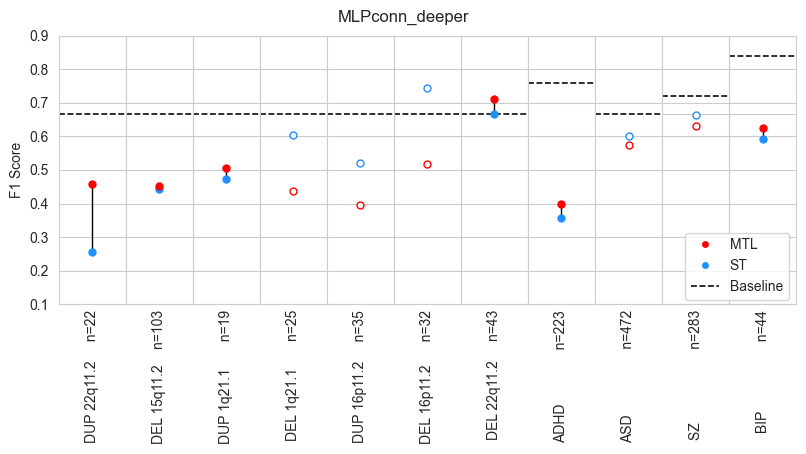

In [11]:
######
# F1 #
######
title = 'MLPconn_deeper'
fig,ax = plt.subplots(1,len(cases),figsize=(8,4.5),sharey=True,sharex=True)
# BIP 0.84
# SZ 0.72
# ADHD 0.76
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.666,0.7,0.72,0.76,0.8,0.84,0.9],
           labels=[0.1,0.2,0.3,0.4,0.5,0.6,None,0.7,None,None,0.8,None,0.9])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_mean_f1 = df_conn.loc[case]['ST_mean_f1']
    mtl_mean_f1 = df_conn.loc[case]['MTL_mean_f1']
    if st_mean_f1 > mtl_mean_f1:
        mfc_mtl = 'white'
        mfc_st = 'white'
        ls =''
    else:
        mfc_mtl = colors[2]
        mfc_st = colors[-2]
        ls = '-'

    ax[j].plot((5,5),(st_mean_f1,mtl_mean_f1),color=colors[0],ls=ls,linewidth=1)
    ax[j].plot(5,st_mean_f1,marker='o',color=colors[-2],ms=5,markerfacecolor=mfc_st)
    ax[j].plot(5,mtl_mean_f1,marker='o',color=colors[2],ms=5,markerfacecolor=mfc_mtl)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(case_labels[j],rotation=90)

    lines = ax[j].get_ygridlines()
    if case not in ['ADHD','BIP','SZ']:
        b = lines[6]
        b.set_color('black')
        b.set_linewidth(1.15)
        b.set_linestyle('--')

        w1 = lines[11] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[9] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[8] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    if case == 'ADHD':
        b = lines[6]
        b.set_color('white')
        b.set_linewidth(1.15)
        b.set_linestyle('-')

        w1 = lines[11] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[9] # ADHD
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')

        w2 = lines[8] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

    if case == 'SZ':
        w1 = lines[11] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[9] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[8] # SZ
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')
    if case == 'BIP':
        w1 = lines[11] # BIP
        w1.set_color('black')
        w1.set_linewidth(1.15)
        w1.set_linestyle('--')

        w2 = lines[9] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[8] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    

    
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o',color='w', label='MTL',
                          markerfacecolor=colors[2]),
        Line2D([0], [0], marker='o', color='w', label='ST',
                          markerfacecolor=colors[-2]),
        Line2D([0], [0], color='black', label='Baseline',
                           linewidth=1.15,ls='--')
                          ]
labels = ['MTL','ST','Baseline']
fig.legend(handles, labels, loc=(0.85,0.34))

ax[0].set_ylabel('F1 Score')
plt.suptitle(title)
plt.ylim(0.1,0.9)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('./figures/conditions_f1_deeper.png'),dpi=300)

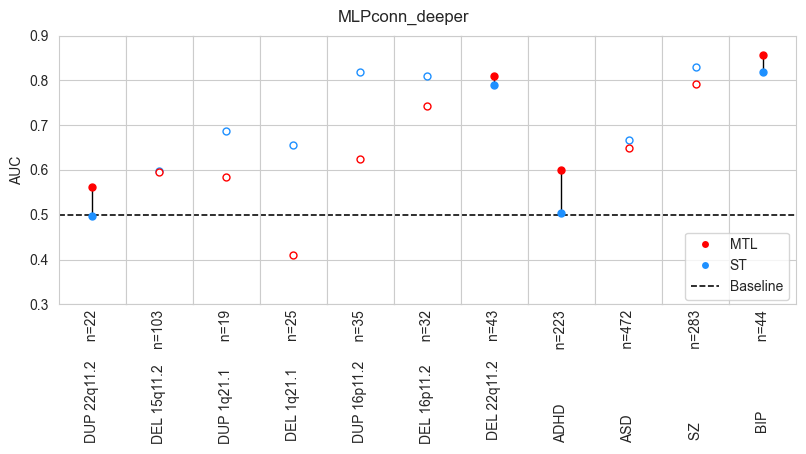

In [12]:
######
# AUC #
######
title = 'MLPconn_deeper'
fig,ax = plt.subplots(1,len(cases),figsize=(8,4.5),sharey=True,sharex=True)
plt.yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_mean_auc = df_conn.loc[case]['ST_mean_auc']
    mtl_mean_auc = df_conn.loc[case]['MTL_mean_auc']
    if st_mean_auc > mtl_mean_auc:
        mfc_mtl = 'white'
        mfc_st = 'white'
        ls =''
    else:
        mfc_mtl = colors[2]
        mfc_st = colors[-2]
        ls = '-'

    ax[j].plot((5,5),(st_mean_auc,mtl_mean_auc),color=colors[0],ls=ls,linewidth=1)
    ax[j].plot(5,st_mean_auc,marker='o',color=colors[-2],ms=5,markerfacecolor=mfc_st)
    ax[j].plot(5,mtl_mean_auc,marker='o',color=colors[2],ms=5,markerfacecolor=mfc_mtl)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(case_labels[j],rotation=90)

    lines = ax[j].get_ygridlines()
    b = lines[2]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')
    

    
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o',color='w', label='MTL',
                          markerfacecolor=colors[2]),
        Line2D([0], [0], marker='o', color='w', label='ST',
                          markerfacecolor=colors[-2]),
        Line2D([0], [0], color='black', label='Baseline',
                           linewidth=1.15,ls='--'),
                          ]
labels = ['MTL','ST','Baseline']
fig.legend(handles, labels, loc=(0.85,0.34))

ax[0].set_ylabel('AUC')
plt.suptitle(title)
plt.ylim(0.3,0.9)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('./figures/conditions_auc_deeper.png'),dpi=300)

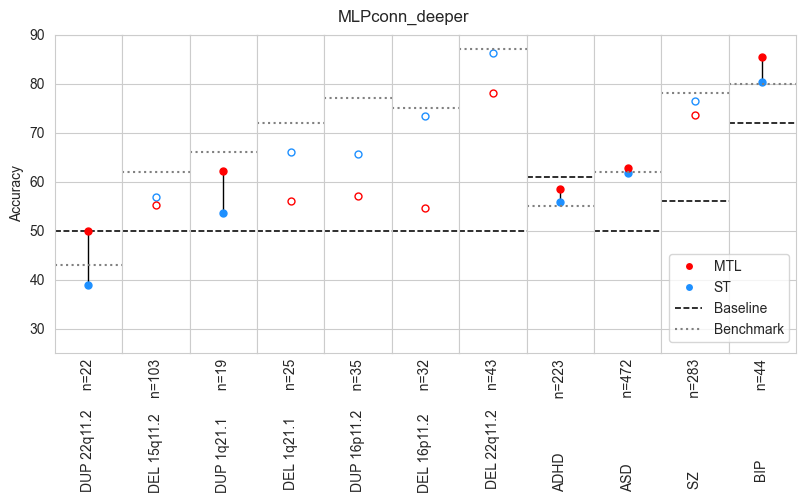

In [14]:
#########################
# ADJUSTED CHANCE LEVEL #
#########################
title = 'MLPconn_deeper'
fig,ax = plt.subplots(1,len(cases),figsize=(8,5),sharey=True,sharex=True)
#plt.yticks([40,50,60,70,80,90])
# BIP: 100 - 28 = 72
# SZ: 100 - 44 = 56
# ADHD: 100 - 39 = 61
plt.yticks([30,40,50,56,60,61,70,72,80,90],
           labels = [30,40,50,None,60,None,70,None,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_acc = df_conn.loc[case]['ST_mean_acc']
    mtl_acc = df_conn.loc[case]['MTL_mean_acc']
    if st_acc > mtl_acc:
        mfc_mtl = 'white'
        mfc_st = 'white'
        ls =''
    else:
        mfc_mtl = colors[2]
        mfc_st = colors[-2]
        ls = '-'

    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls,linewidth=1)
    ax[j].plot(5,st_acc,marker='o',color=colors[-2],ms=5,markerfacecolor=mfc_st)
    ax[j].plot(5,mtl_acc,marker='o',color=colors[2],ms=5,markerfacecolor=mfc_mtl)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(case_labels[j],rotation=90)

    if case == 'DUP22q11_2':
        ax[j].axhline(y=43, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL15q11_2':
        ax[j].axhline(y=62, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DUP1q21_1':
        ax[j].axhline(y=66, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL1q21_1':
        ax[j].axhline(y=72, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DUP16p11_2':
        ax[j].axhline(y=77, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL16p11_2':
        ax[j].axhline(y=75, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL22q11_2':
        ax[j].axhline(y=87, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'ADHD':
        ax[j].axhline(y=55, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'ASD':
        ax[j].axhline(y=62, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'SZ':
        ax[j].axhline(y=78, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'BIP':
        ax[j].axhline(y=80, color='gray', linestyle='dotted',linewidth=1.5)

    lines = ax[j].get_ygridlines()
    if case not in ['ADHD','BIP','SZ']:
        b = lines[2]
        b.set_color('black')
        b.set_linewidth(1.15)
        b.set_linestyle('--')

        w1 = lines[7] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[5] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[3] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    if case == 'ADHD':
        w1 = lines[7] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[5] # ADHD
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')

        w2 = lines[3] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    if case == 'SZ':
        w1 = lines[7] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[5] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[3] # SZ
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')

    if case == 'BIP':
        w1 = lines[7] # BIP
        w1.set_color('black')
        w1.set_linewidth(1.15)
        w1.set_linestyle('--')

        w2 = lines[5] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[3] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o',color='w', label='MTL',
                          markerfacecolor=colors[2]),
        Line2D([0], [0], marker='o', color='w', label='ST',
                          markerfacecolor=colors[-2]),
        Line2D([0], [0], color='black', label='Baseline',
                           linewidth=1.15,ls='--'),
        Line2D([0], [0], color='grey', label='Benchmark',
                           linewidth=1.5,ls='dotted')
                          ]
labels = ['MTL','ST','Baseline', 'Benchmark']
fig.legend(handles, labels, loc=(0.83,0.32))

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(25,90)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('./figures/conditions_acc_deeper.png'),dpi=300)